In [4]:
import numpy as np 
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import keras
from keras.layers import Input, LSTM, Dense,Lambda
from keras.models import Model
from keras.utils import plot_model
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.layers import multiply
from matplotlib import pyplot as plt
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [7]:
#use pre-trained:'Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)'
#vocab: 400K
# api.info("glove-wiki-gigaword-100")
#word_vectors = api.load("glove-wiki-gigaword-100")
#word_vectors.save("glove-wiki-gigaword-100.model")
word_vectors = Word2VecKeyedVectors.load("glove-wiki-gigaword-100.model")

In [8]:
#define the model 
max_qlen = 50 #Truncate if longer
vocab_len = len(word_vectors.vocab)+1
wv_len = word_vectors.get_vector("the").shape[0]

In [9]:
df_train = pd.read_pickle("train_pp.pkl")
df_test = pd.read_pickle("test_pp.pkl")

In [10]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc
145367,145367,229850,229851,Is there only one consciousness?,Is consciousness one for everyone?,1,"[is, there, only, one, consciousness, ?]","[is, consciousness, one, for, everyone, ?]",?,?,True
123169,123169,98309,199206,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,"[which, is, a, suitable, solar, panel, install...","[which, is, a, suitable, solar, panel, install...",?,?,True
57880,57880,101653,101654,Is there any idea for a new and useful mini pr...,Are there any new topics in computer science t...,0,"[is, there, any, idea, for, a, new, and, usefu...","[are, there, any, new, topic, in, computer, sc...",?,?,True
213043,213043,318261,318262,What does it mean if a girl cries after hurtin...,What does it mean if a girl cries without any ...,0,"[what, doe, it, mean, if, a, girl, cry, after,...","[what, doe, it, mean, if, a, girl, cry, withou...",?,?,True
204901,204901,307914,307915,What are some wholesale drop shippers that hav...,What portrait lenses are compatible with the C...,0,"[what, are, some, wholesale, drop, shipper, th...","[what, portrait, lens, are, compatible, with, ...",?,?,True


In [11]:
def words2ints(words,max_len):
    """
    turn a list words to their word indices; padd or truncate to  max_len;
    @params words: List[str]
    return List[int]
    """
    rv = np.zeros((max_len,))
    for i,w in enumerate(words[:max_len]): 
        if w in word_vectors.vocab: 
            rv[i]=word_vectors.vocab[w].index + 1 #Don't forget to shift since keras use 0 for OOV 
        else: 
            rv[i]=0 
    return rv 

In [12]:
df_train['q1_indices'] = df_train['words_1'].apply(lambda x: words2ints(x,max_qlen))
df_train['q2_indices'] = df_train['words_2'].apply(lambda x: words2ints(x,max_qlen))
df_test['q1_indices'] = df_test['words_1'].apply(lambda x: words2ints(x,max_qlen))
df_test['q2_indices'] = df_test['words_2'].apply(lambda x: words2ints(x,max_qlen))


In [13]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc,q1_indices,q2_indices
145367,145367,229850,229851,Is there only one consciousness?,Is consciousness one for everyone?,1,"[is, there, only, one, consciousness, ?]","[is, consciousness, one, for, everyone, ?]",?,?,True,"[15.0, 64.0, 92.0, 49.0, 8658.0, 189.0, 0.0, 0...","[15.0, 8658.0, 49.0, 11.0, 1403.0, 189.0, 0.0,..."
123169,123169,98309,199206,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,"[which, is, a, suitable, solar, panel, install...","[which, is, a, suitable, solar, panel, install...",?,?,True,"[43.0, 15.0, 8.0, 7089.0, 4709.0, 1909.0, 7389...","[43.0, 15.0, 8.0, 7089.0, 4709.0, 1909.0, 7389..."
57880,57880,101653,101654,Is there any idea for a new and useful mini pr...,Are there any new topics in computer science t...,0,"[is, there, any, idea, for, a, new, and, usefu...","[are, there, any, new, topic, in, computer, sc...",?,?,True,"[15.0, 64.0, 131.0, 1160.0, 11.0, 8.0, 51.0, 6...","[33.0, 64.0, 131.0, 51.0, 6284.0, 7.0, 952.0, ..."
213043,213043,318261,318262,What does it mean if a girl cries after hurtin...,What does it mean if a girl cries without any ...,0,"[what, doe, it, mean, if, a, girl, cry, after,...","[what, doe, it, mean, if, a, girl, cry, withou...",?,?,True,"[103.0, 14220.0, 21.0, 1703.0, 84.0, 8.0, 1750...","[103.0, 14220.0, 21.0, 1703.0, 84.0, 8.0, 1750..."
204901,204901,307914,307915,What are some wholesale drop shippers that hav...,What portrait lenses are compatible with the C...,0,"[what, are, some, wholesale, drop, shipper, th...","[what, portrait, lens, are, compatible, with, ...",?,?,True,"[103.0, 33.0, 78.0, 7531.0, 1561.0, 59002.0, 1...","[103.0, 6034.0, 9025.0, 33.0, 11631.0, 18.0, 1..."


In [15]:
q1_seq_train = np.vstack(df_train.q1_indices.values)
q2_seq_train = np.vstack(df_train.q2_indices.values)
q1_seq_test = np.vstack(df_test.q1_indices.values)
q2_seq_test = np.vstack(df_test.q2_indices.values)
y_train = df_train.is_duplicate.values
y_test = df_test.is_duplicate.values

In [16]:
q1_seq_train.shape, q2_seq_train.shape, y_train.shape

((323432, 50), (323432, 50), (323432,))

In [17]:
df_train.shape,df_test.shape

((323432, 13), (80858, 13))

In [18]:
#embedding = word_vectors.get_keras_embedding() #Don't use this, gensim doesn't consider OOV https://github.com/RaRe-Technologies/gensim/blob/2ccc82bf50bcfbee44932c160db076a873cf893e/gensim/models/keyedvectors.py#L1491
embd_weights = np.zeros((vocab_len,wv_len))
embd_weights[1:,:] = word_vectors.vectors


In [19]:
#define the model 
word2vec_layer = Embedding(vocab_len, wv_len, trainable=False,weights=[embd_weights],name="word2vec") #check this Emoji and gensim set the weight in different ways
get_word_weight_layer = Embedding(vocab_len, 1, trainable=False,weights=[np.ones((vocab_len,1))], name="get_word_weight") #generalize tf-idf
#reduce_layer = Lambda(lambda x: K.sum(x, axis=1), output_shape=lambda s: (s[0], s[2]),name="vector_reduction")
lstm_layer = LSTM(100,name="lstm_1")

q1 = Input(shape=(max_qlen,),name="question_1")
q2 = Input(shape=(max_qlen,),name="question_2")

q1_wv = word2vec_layer(q1)
q1_ww = get_word_weight_layer(q1)
q1_wv_ww = multiply([q1_wv,q1_ww])
#q1_final_vec = reduce_layer(q1_wv_ww)
q1_final_vec = lstm_layer(q1_wv_ww)

q2_wv = word2vec_layer(q2)
q2_ww = get_word_weight_layer(q2)
q2_wv_ww = multiply([q2_wv,q2_ww])
#q2_final_vec = reduce_layer(q2_wv_ww)
q2_final_vec = lstm_layer(q2_wv_ww)

merged_vector = keras.layers.concatenate([q1_final_vec, q2_final_vec], axis=-1,name="merge")
predictions = Dense(1, activation='sigmoid',name="sigmoid")(merged_vector)
model = Model(inputs=[q1, q2], outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
model.fit([q1_seq_train,q2_seq_train], y_train, epochs = 20, batch_size = 32, shuffle=True)

Epoch 1/20
323432/323432 [==============================] - 636s 2ms/step - loss: 0.5625 - acc: 0.7100
Epoch 2/20
323432/323432 [==============================] - 590s 2ms/step - loss: 0.5141 - acc: 0.7493
Epoch 3/20
323432/323432 [==============================] - 617s 2ms/step - loss: 0.4944 - acc: 0.7618
Epoch 4/20
323432/323432 [==============================] - 611s 2ms/step - loss: 0.4772 - acc: 0.7731
Epoch 5/20
323432/323432 [==============================] - 622s 2ms/step - loss: 0.4599 - acc: 0.7844
Epoch 6/20
323432/323432 [==============================] - 572s 2ms/step - loss: 0.4454 - acc: 0.7935
Epoch 7/20
323432/323432 [==============================] - 560s 2ms/step - loss: 0.4306 - acc: 0.8020
Epoch 8/20
323432/323432 [==============================] - 540s 2ms/step - loss: 0.4186 - acc: 0.8091
Epoch 9/20
323432/323432 [==============================] - 554s 2ms/step - loss: 0.4074 - acc: 0.8151
Epoch 10/20
323432/323432 [==============================] - 598s 2ms/ste

In [23]:
y_pred_test = model.predict([q1_seq_test,q2_seq_test])
y_pred_train = model.predict([q1_seq_train,q2_seq_train])

In [24]:
auc_test = roc_auc_score(y_test,y_pred_test)
accuracy_test = accuracy_score(y_test,y_pred_test>0.5)
auc_train = roc_auc_score(y_train,y_pred_train)
accuracy_train = accuracy_score(y_train,y_pred_train>0.5)

print("auc_train=%g, auc_test=%g, accuracy_train=%g, accuracy_test=%g" % (auc_train, auc_test, accuracy_train, accuracy_test))

auc_train=0.936734, auc_test=0.828827, accuracy_train=0.866513, accuracy_test=0.768978


Text(0.5, 1.0, 'ROC for testing data')

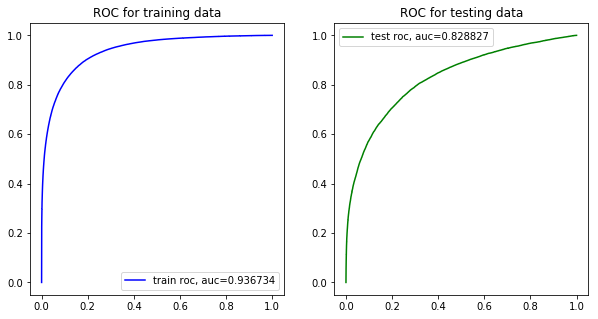

In [25]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_pred_test)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr_train,tpr_train, color="blue", label="train roc, auc=%g" % (auc_train,))
plt.legend()
plt.title("ROC for training data")
plt.subplot(1,2,2)
plt.plot(fpr_test,tpr_test, color="green", label="test roc, auc=%g" % (auc_test,))
plt.legend()
plt.title("ROC for testing data")

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_1 (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
question_2 (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
word2vec (Embedding)            (None, 50, 100)      40000100    question_1[0][0]                 
                                                                 question_2[0][0]                 
__________________________________________________________________________________________________
get_word_weight (Embedding)     (None, 50, 1)        400001      question_1[0][0]                 
          

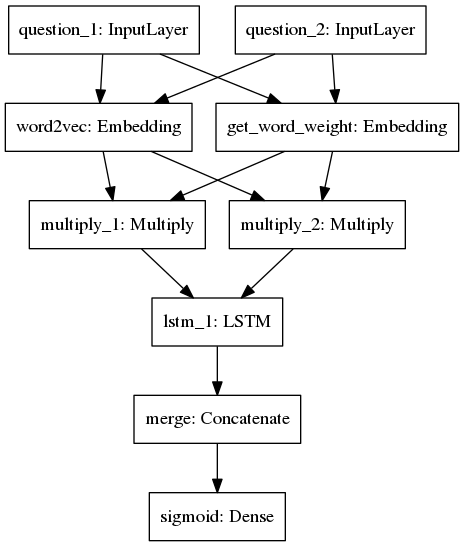

In [21]:
plot_model(model,to_file="model.png")
from IPython.display import Image
Image(filename='model.png') 

In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 280, 256)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 280, 256)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           82176       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][0]                     
          

In [4]:
plot_model(model,to_file="model.png")

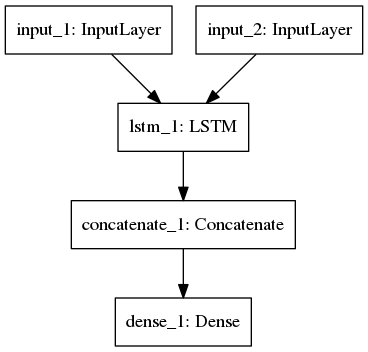

In [5]:
from IPython.display import Image
Image(filename='model.png') 